# 1- Packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.animation as animation
from IPython.display import display, clear_output
import time

%matplotlib inline

D = 10
MAX_EVALUATIONS = 1e6
LIMIT_VARIABLE = [-32.768, 32.768]
PI = np.pi
a = 20
b = 0.2
c = 2*PI
F = 0.8 # differential weight [0, 2]
CR = 0.9 # crossover rate [0, 1]
RANDOM_SEED = 19521832
PATH = 'Experiments/DE/ackley/d10/'

# 2 - [Ackley](https://www.sfu.ca/~ssurjano/ackley.html)
$$
f(x) = -a \exp(-b \sqrt{\frac{1}{d}\sum_{i=1}^{d}x^2_i}) - \exp(\frac{1}{d} \sum_{i=1}^{d}cos(cx_i)) + a + \exp(1)
$$

**Description:**

Dimensions: d

The Ackley function is widely used for testing optimization algorithms. In its two-dimensional form, as shown in the plot above, it is characterized by a nearly flat outer region, and a large hole at the centre. The function poses a risk for optimization algorithms, particularly hillclimbing algorithms, to be trapped in one of its many local minima.

Recommended variable values are: a = 20, b = 0.2 and c = 2π.

**Input Domain:**

The function is usually evaluated on the hypercube xi ∈ [-32.768, 32.768], for all i = 1, …, d, although it may also be restricted to a smaller domain.

**Global Minima:**

$
f(x^*) = 0, at x^* = (0, ..., 0)
$

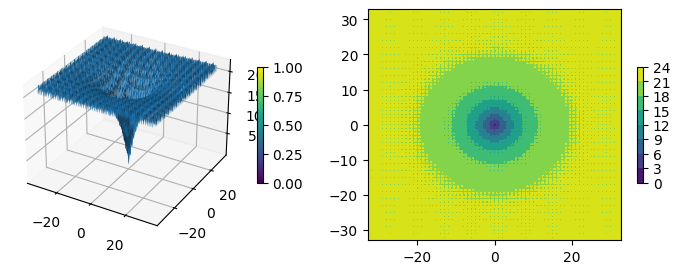

In [2]:
# Visualize 2D
# %matplotlib widget
def f(x1, x2):
    return -a*np.exp(-b*np.sqrt((x1**2 + x2**2)/2)) - np.exp((np.cos(c*x1) + np.cos(c*x2))/2) + a + np.exp(1)

# # (x, y, z)
x1 = np.arange(LIMIT_VARIABLE[0]-0.1, LIMIT_VARIABLE[1]+0.1, 0.01)
x2 = np.arange(LIMIT_VARIABLE[0]-0.1, LIMIT_VARIABLE[1]+0.1, 0.01)
x1_v, x2_v = np.meshgrid(x1, x2)
fx = f(x1_v, x2_v)

fig = plt.figure(figsize=(9, 3))
ax1 = fig.add_subplot(121 , projection='3d')
ax2 = fig.add_subplot(122)

surface = ax1.plot_surface(x1_v, x2_v, fx)
contour = ax2.contourf(x1_v, x2_v, fx)
fig.colorbar(surface, shrink=0.5)
fig.colorbar(contour, shrink=0.5)

plt.show()

# 3 - Implement DE

In [3]:
%matplotlib inline

In [4]:
def initialize_population(pop_size, num_variables, min_value, max_value):
    population = np.random.rand(pop_size, num_variables)*(max_value - min_value) + min_value
    return population

In [5]:
def fitness(ind):
    fitness = -a * np.exp(-b * np.sqrt(np.sum(np.power(ind, 2))/len(ind))) - np.exp(np.sum(np.cos(c*ind))/len(ind)) + a + np.exp(1)
    return fitness

In [6]:
test = np.array([1., 2.])
print(f(1., 2.))
print(fitness(test))

5.422131717799509
5.422131717799509


In [7]:
def pop_fitness(pop):
    fitness = -a *  np.exp(-b * np.sqrt(np.sum(np.power(pop,2), axis=1)/pop.shape[1])) - np.exp(np.sum(np.cos(c*pop), axis=1)/pop.shape[1]) + a + np.exp(1)
    return fitness

In [8]:
test = np.array([[1, 2], [2, 4]])
test_i = np.array([1, 2])
print(fitness(test_i))
print(f(2, 4))
print(pop_fitness(test))

5.422131717799509
9.374287817340646
[5.42213172 9.37428782]


In [9]:
def DE(population_size, num_variables, min_value, max_value, F, CR, max_evaluations, random_seed=19521832, visualize=False):
    
    indices_pop = np.arange(population_size)
    indices_var = np.arange(num_variables)
    
    num_evas = 0
    generations = 0
    
    if visualize:
        fig, ax = plt.subplots(figsize=(5, 5))
    
    # arrays to save data over generations
    best_ind = [] # save best solution over generations i
    best_ind_fitness = [] #
    num_evaluations = [] #
    
    np.random.seed(random_seed)
    # 1 - initialize population
    population = initialize_population(population_size, num_variables, min_value, max_value)
    
    # 2 - loop over each inds
    while True:
        for idx in range(population_size):
            # 2.1 create mutant ind
            r = np.random.choice(np.delete(indices_pop, idx), 3) # index of 3 other inds
            mutant_ind = population[r[0]] + F * (population[r[1]] - population[r[2]])
            mutant_ind = np.clip(mutant_ind, min_value, max_value)

            # 2.2 crossover
            random_j = np.random.choice(indices_var)
            cr_prob = np.random.rand(num_variables)
            mask = cr_prob < CR
            trial_ind = mask*mutant_ind + (1-mask)*population[idx]
            trial_ind[random_j] = mutant_ind[random_j]

            # 2.3 selection
            if fitness(trial_ind) < fitness(population[idx]):
                population[idx] = trial_ind
            num_evas += 2
        
        # save information of this generation
        best_ind_idx = np.argmin(pop_fitness(population))
        best_ind.append(list(population[best_ind_idx, :]))
        best_ind_fitness.append(fitness(population[best_ind_idx, :]))
        num_evaluations.append(num_evas)

        # visualize  
        if visualize:
            ax.clear()
            ax.contourf(x1_v, x2_v, fx)
            ax.scatter(population[:, 0], population[:, 1], c='w')
            ax.scatter(population[best_ind_idx, 0], population[best_ind_idx, 1], c='r')
            best_ind_numpy = np.asarray(best_ind)
            ax.plot(best_ind_numpy[:, 0], best_ind_numpy[:, 1])
            ax.text(10, 10, 'Gen: '+str(generations))
            display(fig)
            plt.pause(0.2)
            if num_evas >= max_evaluations:
                break
            clear_output(wait=True)
        if num_evas >= max_evaluations:
            break
        
        generations += 1
    print(f'FINISH')
        
#         print(f'Gen: {generations}')
#         print(f'fitness: {pop_fitness(population)}')
    return best_ind[-1], best_ind, best_ind_fitness, num_evaluations

In [10]:
def run_10_times(population_size, num_variables, min_value, max_value, F, CR, max_evaluations, random_seed=19521832, visualize=False):
    for i in range(10):
        print(f'Time: {i} random seed: {random_seed}')
        
        solution, best_inds, best_ind_fitness, num_evaluations = DE(population_size, num_variables, min_value, max_value, F, CR, max_evaluations, random_seed, visualize)
        
        evaluations_fitness = np.concatenate((np.expand_dims(num_evaluations, axis=1), np.expand_dims(best_ind_fitness, axis=1)), axis=1)
        
        np.savetxt(PATH + str(N) + '/' + str(random_seed) + '.txt', evaluations_fitness)
        
        random_seed+=1

## 3.2 - Population size 32

In [82]:
N = 32
run_10_times(N, D, LIMIT_VARIABLE[0], LIMIT_VARIABLE[1], F, CR, MAX_EVALUATIONS, RANDOM_SEED, visualize=False)

Time: 0 random seed: 19521832
FINISH
Time: 1 random seed: 19521833
FINISH
Time: 2 random seed: 19521834
FINISH
Time: 3 random seed: 19521835
FINISH
Time: 4 random seed: 19521836
FINISH
Time: 5 random seed: 19521837
FINISH
Time: 6 random seed: 19521838
FINISH
Time: 7 random seed: 19521839
FINISH
Time: 8 random seed: 19521840
FINISH
Time: 9 random seed: 19521841
FINISH


## 3.2 - Population size 64

In [83]:
N = 64
run_10_times(N, D, LIMIT_VARIABLE[0], LIMIT_VARIABLE[1], F, CR, MAX_EVALUATIONS, RANDOM_SEED, visualize=False)

Time: 0 random seed: 19521832
FINISH
Time: 1 random seed: 19521833
FINISH
Time: 2 random seed: 19521834
FINISH
Time: 3 random seed: 19521835
FINISH
Time: 4 random seed: 19521836
FINISH
Time: 5 random seed: 19521837
FINISH
Time: 6 random seed: 19521838
FINISH
Time: 7 random seed: 19521839
FINISH
Time: 8 random seed: 19521840
FINISH
Time: 9 random seed: 19521841
FINISH


## 3.3 - Population size 128

In [84]:
N = 128
run_10_times(N, D, LIMIT_VARIABLE[0], LIMIT_VARIABLE[1], F, CR, MAX_EVALUATIONS, RANDOM_SEED, visualize=False)

Time: 0 random seed: 19521832
FINISH
Time: 1 random seed: 19521833
FINISH
Time: 2 random seed: 19521834
FINISH
Time: 3 random seed: 19521835
FINISH
Time: 4 random seed: 19521836
FINISH
Time: 5 random seed: 19521837
FINISH
Time: 6 random seed: 19521838
FINISH
Time: 7 random seed: 19521839
FINISH
Time: 8 random seed: 19521840
FINISH
Time: 9 random seed: 19521841
FINISH


## 3.4 - Population size 256

In [85]:
N = 256
run_10_times(N, D, LIMIT_VARIABLE[0], LIMIT_VARIABLE[1], F, CR, MAX_EVALUATIONS, RANDOM_SEED, visualize=False)

Time: 0 random seed: 19521832
FINISH
Time: 1 random seed: 19521833
FINISH
Time: 2 random seed: 19521834
FINISH
Time: 3 random seed: 19521835
FINISH
Time: 4 random seed: 19521836
FINISH
Time: 5 random seed: 19521837
FINISH
Time: 6 random seed: 19521838
FINISH
Time: 7 random seed: 19521839
FINISH
Time: 8 random seed: 19521840
FINISH
Time: 9 random seed: 19521841
FINISH


## 3.5 - Population size 512

In [86]:
N = 512
run_10_times(N, D, LIMIT_VARIABLE[0], LIMIT_VARIABLE[1], F, CR, MAX_EVALUATIONS, RANDOM_SEED, visualize=False)

Time: 0 random seed: 19521832
FINISH
Time: 1 random seed: 19521833
FINISH
Time: 2 random seed: 19521834
FINISH
Time: 3 random seed: 19521835
FINISH
Time: 4 random seed: 19521836
FINISH
Time: 5 random seed: 19521837
FINISH
Time: 6 random seed: 19521838
FINISH
Time: 7 random seed: 19521839
FINISH
Time: 8 random seed: 19521840
FINISH
Time: 9 random seed: 19521841
FINISH


## 3.6 - Population size 1024

In [87]:
N = 1024
run_10_times(N, D, LIMIT_VARIABLE[0], LIMIT_VARIABLE[1], F, CR, MAX_EVALUATIONS, RANDOM_SEED, visualize=False)

Time: 0 random seed: 19521832
FINISH
Time: 1 random seed: 19521833
FINISH
Time: 2 random seed: 19521834
FINISH
Time: 3 random seed: 19521835
FINISH
Time: 4 random seed: 19521836
FINISH
Time: 5 random seed: 19521837
FINISH
Time: 6 random seed: 19521838
FINISH
Time: 7 random seed: 19521839
FINISH
Time: 8 random seed: 19521840
FINISH
Time: 9 random seed: 19521841
FINISH


# 4 - Create gif file

In [46]:
# import numpy as np
# import matplotlib.pyplot as plt


# fig = plt.figure()


# def f(x, y):
#     return np.sin(x) + np.cos(y)


# x = np.linspace(0, 2 * np.pi, 120)
# y = np.linspace(0, 2 * np.pi, 100).reshape(-1, 1)
# # ims is a list of lists, each row is a list of artists to draw in the
# # current frame; here we are just animating one artist, the image, in
# # each frame
# ims = []
# for i in range(60):
#     x += np.pi / 15.
#     y += np.pi / 20.
#     im = plt.imshow(f(x, y), animated=True)
#     ims.append([im])

# ani = animation.ArtistAnimation(fig, ims, interval=2, blit=True,
#                                 repeat_delay=1)

# # ani.save('dynamic_images.gif')

# plt.show()

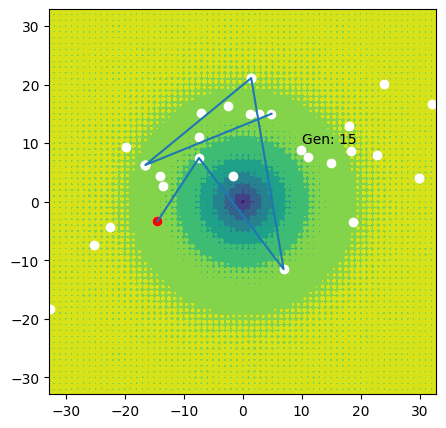

FINISH


In [11]:
N = 32
MAX_EVALUATIONS = 1000
result = DE(N, D, LIMIT_VARIABLE[0], LIMIT_VARIABLE[1], F, CR, MAX_EVALUATIONS, RANDOM_SEED, visualize=True)